In [2]:
import mne
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from mne.decoding import Scaler, Vectorizer, cross_val_multiscore
from mne.decoding import LinearModel, SlidingEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from pathlib import Path
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.colors import TwoSlopeNorm

In [3]:
# ------------------
# Paths & I/O
# ------------------
LOCALIZER_EPO = Path("/Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Data/Pilot/BIDS/derivatives/mne-bids-pipeline/sub-01/meg/sub-01_task-localizer_epo.fif")
BEHAVIOR_XPD = Path("/Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Data/Pilot/Behavior/sub-01/data.xpd")

epochs = mne.read_epochs(LOCALIZER_EPO)
meta = epochs.metadata.reset_index(drop=True)

Reading /Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Data/Pilot/BIDS/derivatives/mne-bids-pipeline/sub-01/meg/sub-01_task-localizer_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Adding metadata with 3 columns
960 matching events found
No baseline correction applied
0 projection items activated


In [8]:
# ------------------
# Behavioral dataset
# ------------------
behavior = (
    pd.read_csv(BEHAVIOR_XPD, comment="#")
      .query("trial_type == 'localizer' and trial_block != 0")
      .assign(
          subject_id = 1,
          trial_number = lambda d: d.trial_number - 64
      )
      .loc[:, [
          "subject_id", "trial_type", "trial_block", "trial_number",
          "shape1", "label1", "correct_key",
          "participant_response", "reaction_time", "participant_correct"
      ]]
      .reset_index(drop=True)
)

# ------------------
# Align & merge by row index
# ------------------
assert len(behavior) == len(meta), f"Row mismatch: behavior={len(behavior)} vs meta={len(meta)}"

epochs.metadata = (
    behavior
      .join(meta, rsuffix="_meta")
      .rename(columns={"trial_type": "task", "event_name": "stimulus_type"})
      .replace({"carré": "carre", "losenge": "losange"})
      .assign(
      meaning=lambda d: d["shape1"].fillna(d["label1"]),
      stimulus=lambda d: d["stimulus_type"].astype(str) + "_" + d["meaning"].astype(str),
      meaning_superordinate=lambda d: np.select(
              [
                  d["meaning"].isin(["biche", "dinde"]),
                  d["meaning"].isin(["pince", "lampe"]),
              ],
              [
                  "nonshape",
                  "nonshape",
              ],
              default="shape",
          )
      )
      .loc[:, [
          "subject_id", "task", "trial_block", "trial_number",
          "stimulus_type", "meaning", "meaning_superordinate", "stimulus", 
          "participant_response", "reaction_time", "participant_correct"
      ]]
      )

epochs.metadata.to_csv("metadata.csv", index=False)

Replacing existing metadata with 11 columns


In [9]:
epochs.metadata["meaning"]

0        carre
1        croix
2        dinde
3        biche
4       cercle
        ...   
955      croix
956      carre
957      biche
958    losange
959      carre
Name: meaning, Length: 960, dtype: object

In [4]:
unique_labels = sorted(list(set(epochs.metadata['event_name'])))
mapping = {v:(i+1) for i, v in enumerate(unique_labels)}
labels = epochs.metadata['event_name'].map(mapping).to_list()

In [36]:
# clf = make_pipeline(
#     Scaler(epochs.info),  # Normalisation des données
#     Vectorizer(),  # Transforme les données 3D en 2D pour sklearn
#     LinearModel(LogisticRegression(solver='liblinear', C=1))  # Modèle de classification
# )

clf = make_pipeline(StandardScaler(), SVC(C=1, kernel='linear', decision_function_shape='ovo', probability = True))

In [7]:
# Création d'un estimateur glissant pour le décodage temporel
time_decoding = SlidingEstimator(clf, n_jobs=1, scoring='accuracy', verbose=True)

In [ ]:
# Execute cross-validation
print("--- Executing the cross-validation ---")
epochs.decimate(2)
X = epochs.pick_types(meg='mag').get_data()
y = np.array(labels)







scores = cross_val_multiscore(time_decoding, X, y, cv=5, n_jobs=-1)


--- Exécution de la validation croisée ---
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
  0%|          | Fitting SlidingEstimator : 0/151 [00:00<?,       ?it/s]
  0%|          | Fitting SlidingEstimator : 0/151 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/151 [00:00<?,       ?it/s]


  0%|          | Fitting SlidingEstimator : 0/151 [00:00<?,       ?it/s]



  1%|          | Fitting SlidingEstimator : 1/151 [00:02<05:07,    2.05s/it][A
  1%|          | Fitting SlidingEstimator : 1/151 [00:02<05:13,    2.09s/it]

  1%|          | Fitting SlidingEstimator : 1/151 [00:02<05:08,    2.05s/it]


  1%|          | Fitting SlidingEstimator : 1/151 [00:02<05:01,    2.01s/it]



  1%|▏         | Fitting SlidingEstimator : 2/151 [00:03<04:56,    1.99s/it]
  1%|▏         | Fitting SlidingEstimator : 2/151 [00:03<04:53,    1.97s/it]

  1%|▏         | Fitting SlidingEstimator : 2/151 [00:03<04:45,    1.91s/it]


  1%|▏         | Fitting SlidingEstimator : 2/151 [00:03<04:50,    1.95s/it]


--- Visualisation des résultats de décodage ---


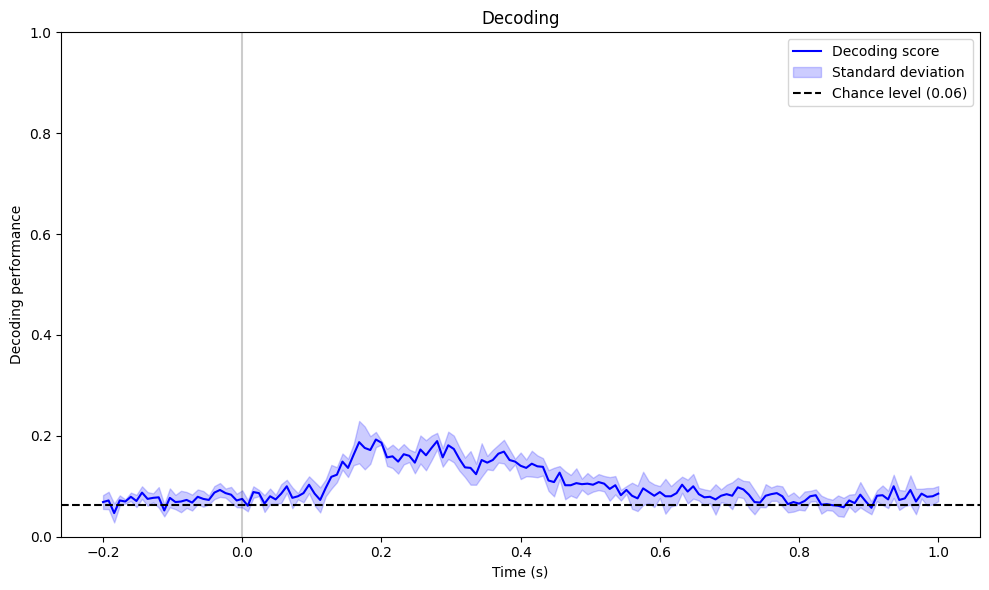

In [ ]:
mean_scores = np.mean(scores, axis=0)
std_scores = np.std(scores, axis=0)

n_classes = len(mapping.keys())
# Visualisation des résultats de décodage
print("--- Visualisation des résultats de décodage ---")
# Création de la figure
fig, ax = plt.subplots(figsize=(10, 6))

# Tracé de la courbe de performance du décodage
times = epochs.times
ax.plot(times, mean_scores, label='Decoding score', color='blue')
ax.fill_between(times, mean_scores - std_scores, mean_scores + std_scores,
                color='blue', alpha=0.2, label='Standard deviation')

# Ajout du niveau de chance
chance_level = 1.0 / n_classes
ax.axhline(chance_level, color='k', linestyle='--', label=f'Chance level ({chance_level:.2f})')

# Formatage du graphique
ax.set_xlabel('Time (s)')
ax.set_ylabel('Decoding performance')
ax.set_title('Decoding')
ax.legend()
ax.set_ylim([0, 1])
ax.axvline(0, color='k', linestyle='-', alpha=0.2)

plt.tight_layout()
plt.show()

In [10]:
np.save('initial_decoding_ovo.npy', scores)

## Confusion matrix

### By modality: Image vs word

In [11]:
# ==================
# Time-resolved confusion matrix video
# ==================
print("--- Computing time-resolved confusion matrices ---")
# Use only magnetometers already picked above; X has shape (n_trials, n_sensors, n_times)
n_trials, n_sensors, n_times = X.shape

# Ensure deterministic, stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Establish a stable class order [1..n_classes] matching our 'labels'
class_order = np.array(sorted(set(y)))
assert len(class_order) == n_classes, f"Expected {n_classes} classes, got {len(class_order)}"

# Allocate array to store confusion matrices (time, true_class, pred_class)
cms = np.zeros((n_times, n_classes, n_classes), dtype=float)

# For each time point, get cross-validated predictions and build a confusion matrix
for ti in range(n_times):
    Xt = X[:, :, ti]  # shape (n_trials, n_sensors)
    # cross-validated predictions at this time point
    y_pred = cross_val_predict(clf, Xt, y, cv=cv, n_jobs=-1, method='predict')
    cm = confusion_matrix(y, y_pred, labels=class_order)

    # Normalize rows to sum to 1 (per true class) to reflect accuracies
    with np.errstate(invalid='ignore', divide='ignore'):
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_norm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums != 0)
    cms[ti] = cm_norm

print("--- Confusion matrices computed ---")


--- Computing time-resolved confusion matrices ---
--- Confusion matrices computed ---


Saved video to: confusion_over_time.mp4


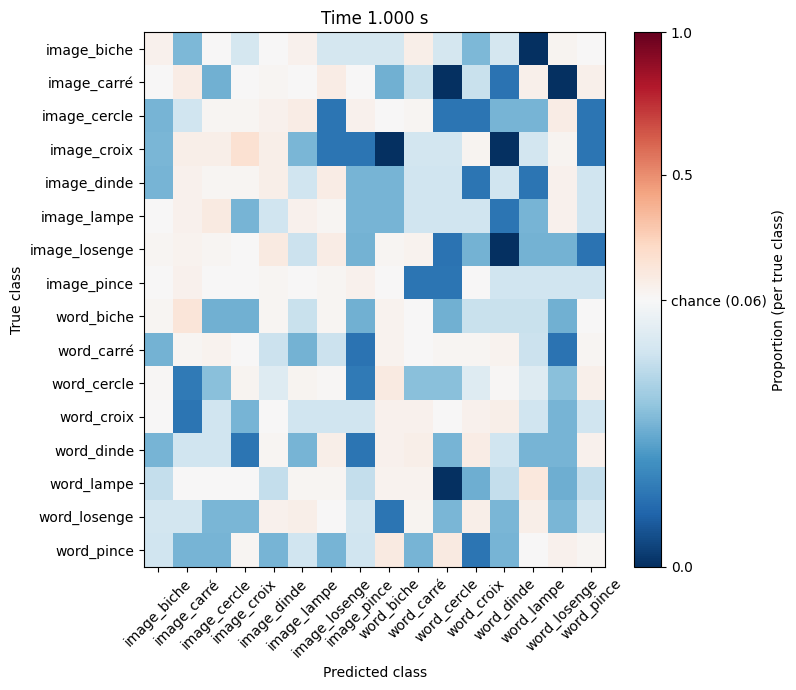

In [12]:
# ------------------
# Create and save an MP4 video
# ------------------
OUT_VIDEO = Path("confusion_over_time.mp4")

# Define a diverging colormap centered at chance
fig_cm, ax_cm = plt.subplots(figsize=(8, 7))
norm = TwoSlopeNorm(vmin=0.0, vcenter=1.0/n_classes, vmax=1.0)
im = ax_cm.imshow(cms[0], norm=norm, cmap="RdBu_r",
                  origin='upper', interpolation='nearest', aspect='auto')

# Colorbar with explicit ticks
cbar = plt.colorbar(im, ax=ax_cm)
cbar.set_label("Proportion (per true class)")
cbar.set_ticks([0.0, 1.0/n_classes, 0.5, 1.0])
cbar.set_ticklabels([0.0, f"chance ({1.0/n_classes:.2f})", 0.5, 1.0])

ax_cm.set_xlabel("Predicted class")
ax_cm.set_ylabel("True class")
ax_cm.set_title(f"Time {times[0]:.3f} s")
ax_cm.set_xticks(np.arange(n_classes))
ax_cm.set_yticks(np.arange(n_classes))
ax_cm.set_xticklabels(unique_labels, rotation = 45)
ax_cm.set_yticklabels(unique_labels)
plt.tight_layout()

def update(frame_idx):
    im.set_data(cms[frame_idx])
    ax_cm.set_title(f"Time {times[frame_idx]:.3f} s")
    return (im,)

anim = FuncAnimation(fig_cm, update, frames=n_times, interval=100, blit=True)

writer = FFMpegWriter(fps=30, metadata={'artist': 'decoding_first.py'})
anim.save(str(OUT_VIDEO), writer=writer)
print(f"Saved video to: {OUT_VIDEO}")

### By concept

In [ ]:
# Custom order
bases = ['biche', 'dinde', 
         'lampe', 'pince', 
         'carré', 'cercle', 'croix', 'losenge']

# Build new order: image_X then word_X
by_concept = []
for base in bases:
    by_concept.append(f"image_{base}")
    by_concept.append(f"word_{base}")

# Use your own order, mapped through the original string labels
inv_mapping = {v: k for k, v in mapping.items()}       # num → string
by_concept_str = by_concept                        # your chosen list
concept_order_num = [mapping[label] for label in by_concept_str]

class_order = np.array(concept_order_num)

In [47]:
# Allocate array to store confusion matrices (time, true_class, pred_class)
cms = np.zeros((n_times, n_classes, n_classes), dtype=float)

# For each time point, get cross-validated predictions and build a confusion matrix
for ti in range(n_times):
    Xt = X[:, :, ti]  # shape (n_trials, n_sensors)
    # cross-validated predictions at this time point
    y_pred = cross_val_predict(clf, Xt, y, cv=cv, n_jobs=-1, method='predict')
    cm = confusion_matrix(y, y_pred, labels=class_order)

    # Normalize rows to sum to 1 (per true class) to reflect accuracies
    with np.errstate(invalid='ignore', divide='ignore'):
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_norm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums != 0)
    cms[ti] = cm_norm

print("--- Confusion matrices computed ---")

--- Confusion matrices computed ---


Saved video to: confusion_over_time_concepts.mp4


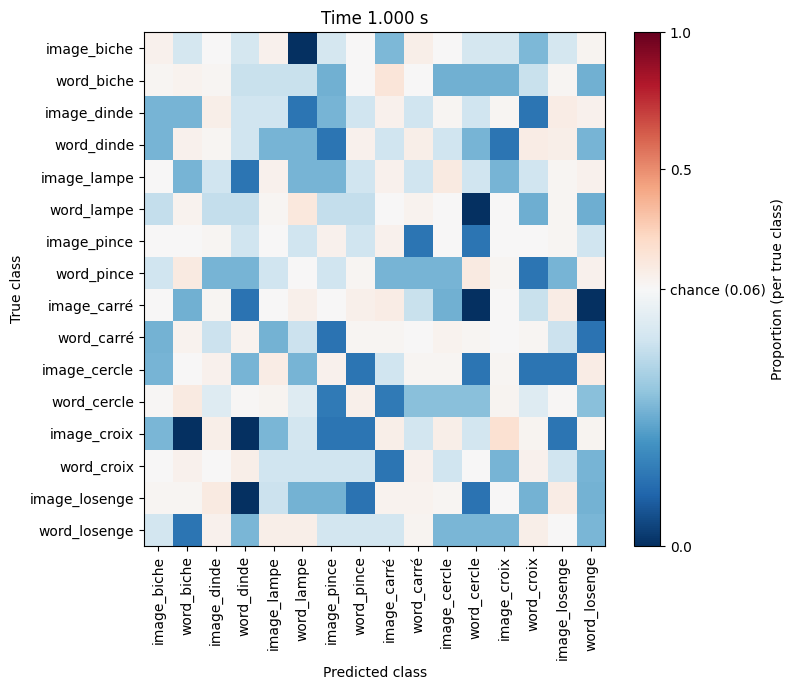

In [49]:
# ------------------
# Create and save an MP4 video
# ------------------
OUT_VIDEO = Path("confusion_over_time_concepts.mp4")

# Define a diverging colormap centered at chance
fig_cm, ax_cm = plt.subplots(figsize=(8, 7))
norm = TwoSlopeNorm(vmin=0.0, vcenter=1.0/n_classes, vmax=1.0)
im = ax_cm.imshow(cms[0], norm=norm, cmap="RdBu_r",
                  origin='upper', interpolation='nearest', aspect='auto')

# Colorbar with explicit ticks
cbar = plt.colorbar(im, ax=ax_cm)
cbar.set_label("Proportion (per true class)")
cbar.set_ticks([0.0, 1.0/n_classes, 0.5, 1.0])
cbar.set_ticklabels([0.0, f"chance ({1.0/n_classes:.2f})", 0.5, 1.0])

ax_cm.set_xlabel("Predicted class")
ax_cm.set_ylabel("True class")
ax_cm.set_title(f"Time {times[0]:.3f} s")
ax_cm.set_xticks(np.arange(n_classes))
ax_cm.set_yticks(np.arange(n_classes))
ax_cm.set_xticklabels(by_concept, rotation = 90)
ax_cm.set_yticklabels(by_concept)
plt.tight_layout()

def update(frame_idx):
    im.set_data(cms[frame_idx])
    ax_cm.set_title(f"Time {times[frame_idx]:.3f} s")
    return (im,)

anim = FuncAnimation(fig_cm, update, frames=n_times, interval=100, blit=True)

writer = FFMpegWriter(fps=30, metadata={'artist': 'decoding_first.py'})
anim.save(str(OUT_VIDEO), writer=writer)
print(f"Saved video to: {OUT_VIDEO}")